In [4]:
pip install shap

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score, roc_auc_score, roc_curve
import shap
#am importat toate librariile de care avem nevoie
#daca voi folosi o functie/o linie de mai multe ori o voi comenta numai prima data cand o folosesc

In [6]:
data = pd.read_csv("/content/datasetalphabank.csv")
#Am preluat datele din fisierul .csv

In [7]:
data
#am vizualizat datele

,ID,Attrition_Flag,Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Used_Bal,Total_Unused_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,358999029,Existing Customer,19,M,0.0,Graduate,Single,Less than $40K,Blue,13,...,4,2,2843.50,2019,566.0,0.525,2644,40,0.481,0.781
1,389722554,Existing Customer,19,M,0.0,Graduate,Single,$40K - $60K,Blue,13,...,1,2,3619.00,1616,1674.0,0.466,2781,54,0.350,0.491
2,357247629,Existing Customer,19,M,0.0,College,Single,Less than $40K,Blue,36,...,1,3,1582.13,479,959.3,0.553,1786,37,0.370,0.333
3,378032716,Existing Customer,19,M,0.0,NaN,Single,$40K - $60K,Green,19,...,3,2,2405.70,1597,590.0,0.777,2560,46,0.314,0.730
4,406734729,Existing Customer,19,F,1.0,Graduate,Single,$40K - $60K,Blue,20,...,4,3,1582.13,673,765.3,0.595,2167,48,0.412,0.468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,393674304,Existing Customer,54,M,0.0,High School,Married,Less than $40K,Blue,56,...,3,3,3577.20,1495,1757.0,0.581,1227,15,0.875,0.460
10123,357976441,Existing Customer,54,M,0.0,High School,Married,$40K - $60K,Blue,36,...,4,2,4915.90,1125,3344.0,1.363,1765,34,1.615,0.252
10124,357716304,Existing Customer,0,M,4.0,NaN,Single,$60K - $80K,Blue,36,...,1,0,24554.20,953,21369.0,0.769,1348,34,1.125,0.043
10125,386686554,Existing Customer,0,F,4.0,High School,Married,Less than $40K,Blue,43,...,3,0,3108.60,2070,756.0,0.541,1025,28,0.647,0.732


In [8]:
data.shape
#am aflat nr de elemente si coloane al "data"

(10127, 21)

In [9]:
pd.set_option("display.max_columns",None)
#scoatem restrictiile de afisare al nr. maxim de coloane

In [10]:
data.describe(include = "object")
#afisare a obiectelor din "data" (tot ce nu este numeric)

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,10127,10127,8607,9378,9013,10127
unique,2,2,6,3,5,6
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,8500,5358,3128,4687,3560,9428


In [11]:
data["Attrition_Flag"]

0        Existing Customer
1        Existing Customer
2        Existing Customer
3        Existing Customer
4        Existing Customer
               ...        
10122    Existing Customer
10123    Existing Customer
10124    Existing Customer
10125    Existing Customer
10126    Existing Customer
Name: Attrition_Flag, Length: 10127, dtype: object

In [12]:
data["Attrition_Flag"].isnull().sum()
#verificam daca "Attrition_Flag" are valori nule

0

In [13]:
data["Attrition_Flag"].unique()
#verificam cate variante unice are "Attrition_Flag"

array(['Existing Customer', 'Attrited Customer'], dtype=object)

In [14]:
data["Attrition_Flag"].value_counts()
#verificam nr de valori din "Attrition_Flag"

Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

In [15]:
data["Attrition_Flag"].value_counts()/len(data)*100
#le vedem sub forma de procent

Attrition_Flag
Existing Customer    83.934038
Attrited Customer    16.065962
Name: count, dtype: float64

In [16]:
data["Attrition_Flag"] = data["Attrition_Flag"].map({"Existing Customer":0, "Attrited Customer":1})
#rescriem datele unde 0 este "Existing Customer" si 1 este "Attrited Customer"

In [17]:
data["Attrition_Flag"]

0        0
1        0
2        0
3        0
4        0
        ..
10122    0
10123    0
10124    0
10125    0
10126    0
Name: Attrition_Flag, Length: 10127, dtype: int64

In [18]:
categorical_features =[col for col in data.columns if data[col].dtypes == "object"]
data[categorical_features].head()
#aflam atributele categorice

,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
0,M,Graduate,Single,Less than $40K,Blue
1,M,Graduate,Single,$40K - $60K,Blue
2,M,College,Single,Less than $40K,Blue
3,M,NaN,Single,$40K - $60K,Green
4,F,Graduate,Single,$40K - $60K,Blue


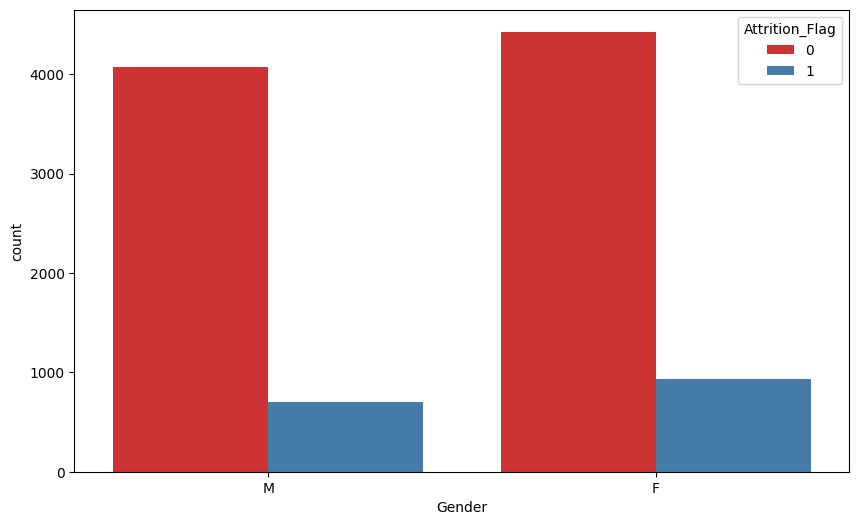

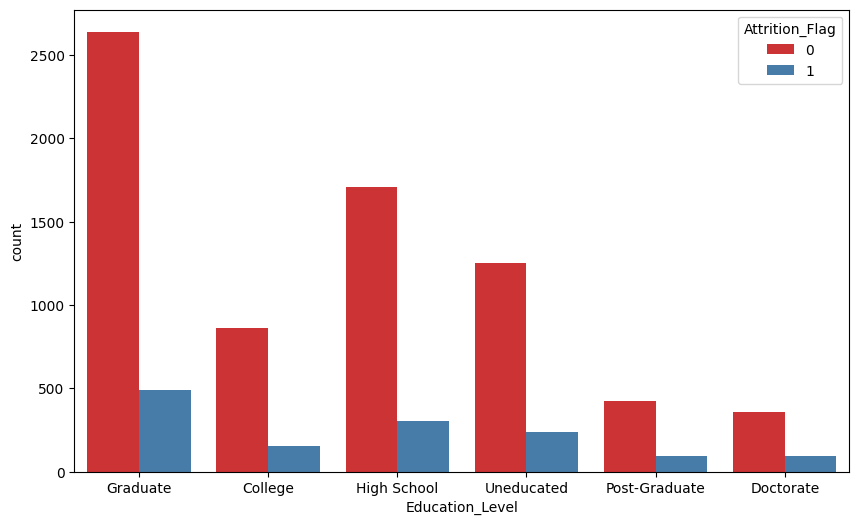

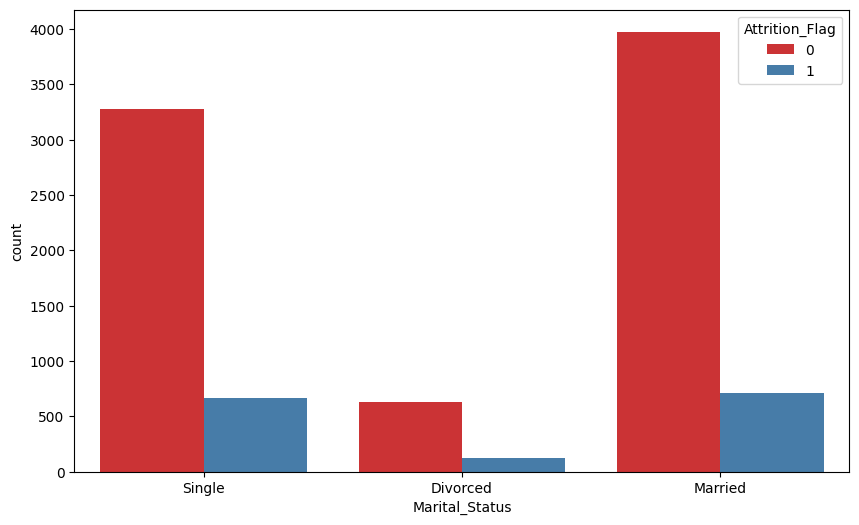

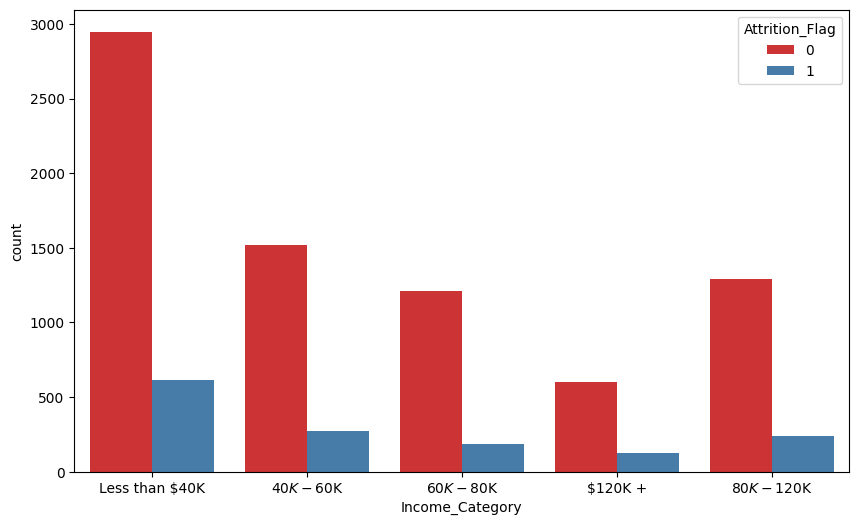

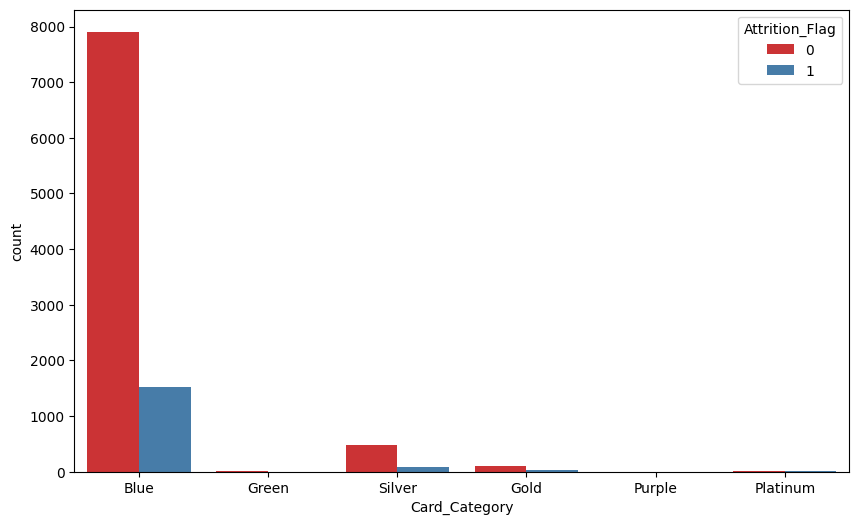

In [19]:
for col in categorical_features:
  f,ax=plt.subplots(figsize = (10,6))
  ax = sns.countplot(x = col, data = data,palette = "Set1", hue = "Attrition_Flag")
  plt.show()
  #facem un grafic cu legatura dintre atributele categorice si "Attrition_Flag"

In [20]:
data[categorical_features].isnull().sum()

Gender                0
Education_Level    1520
Marital_Status      749
Income_Category    1114
Card_Category         0
dtype: int64

In [21]:
data["Education_Level"].value_counts()

Education_Level
Graduate         3128
High School      2012
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64

In [22]:
data["Education_Level"] = data["Education_Level"].fillna("Other")
#variabilele necunoscute le vom nota cu "Other"

In [23]:
data[categorical_features].isnull().sum()

Gender                0
Education_Level       0
Marital_Status      749
Income_Category    1114
Card_Category         0
dtype: int64

In [24]:
data["Education_Level"].value_counts()/len(data)*100

Education_Level
Graduate         30.887726
High School      19.867680
Other            15.009381
Uneducated       14.683519
College          10.002962
Post-Graduate     5.095290
Doctorate         4.453441
Name: count, dtype: float64

In [25]:
data[categorical_features].nunique()
#aflam numarul de variabile unice care fac parte din fiecare categorie

Gender             2
Education_Level    7
Marital_Status     3
Income_Category    5
Card_Category      6
dtype: int64

In [26]:
data["Marital_Status"].value_counts()/len(data)*100

Marital_Status
Married     46.282216
Single      38.935519
Divorced     7.386195
Name: count, dtype: float64

In [27]:
data["Marital_Status"] = data["Marital_Status"].fillna("Unknown")

In [28]:
data["Marital_Status"].value_counts()/len(data)*100

Marital_Status
Married     46.282216
Single      38.935519
Unknown      7.396070
Divorced     7.386195
Name: count, dtype: float64

In [29]:
data["Income_Category"].value_counts()

Income_Category
Less than $40K    3560
$40K - $60K       1789
$80K - $120K      1535
$60K - $80K       1402
$120K +            727
Name: count, dtype: int64

In [30]:
data[categorical_features].isnull().sum()

Gender                0
Education_Level       0
Marital_Status        0
Income_Category    1114
Card_Category         0
dtype: int64

In [31]:
data["Income_Category"] = data["Income_Category"].fillna("Other")

In [32]:
data["Income_Category"].value_counts()/len(data)*100

Income_Category
Less than $40K    35.153550
$40K - $60K       17.665646
$80K - $120K      15.157500
$60K - $80K       13.844179
Other             11.000296
$120K +            7.178829
Name: count, dtype: float64

In [33]:
values = data["Income_Category"].value_counts()/len(data)*100

In [34]:
data["Income_Category"]=np.where(data["Income_Category"].isin(values.index[4:]),"Other",data["Income_Category"])
#voi transforma tot ce se afla pe lista ca si valoare extrema (superioara in acest caz) drept "Other"

In [35]:
data["Income_Category"].value_counts()/len(data)*100

Income_Category
Less than $40K    35.153550
Other             18.179125
$40K - $60K       17.665646
$80K - $120K      15.157500
$60K - $80K       13.844179
Name: count, dtype: float64

In [36]:
data[categorical_features].isnull().sum()

Gender             0
Education_Level    0
Marital_Status     0
Income_Category    0
Card_Category      0
dtype: int64

In [37]:
data[categorical_features].nunique()

Gender             2
Education_Level    7
Marital_Status     4
Income_Category    5
Card_Category      6
dtype: int64

In [38]:
print(categorical_features)

['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


In [39]:
dummies = pd.get_dummies(data,columns = categorical_features)
#afisez toate variabilele de tip dummy

In [40]:
dummies

,ID,Attrition_Flag,Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Used_Bal,Total_Unused_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Other,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Other,Card_Category_Blue,Card_Category_Gold,Card_Category_Green,Card_Category_Platinum,Card_Category_Purple,Card_Category_Silver
0,358999029,0,19,0.0,13,6,4,2,2843.50,2019,566.0,0.525,2644,40,0.481,0.781,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False
1,389722554,0,19,0.0,13,6,1,2,3619.00,1616,1674.0,0.466,2781,54,0.350,0.491,False,True,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False
2,357247629,0,19,0.0,36,4,1,3,1582.13,479,959.3,0.553,1786,37,0.370,0.333,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False
3,378032716,0,19,0.0,19,5,3,2,2405.70,1597,590.0,0.777,2560,46,0.314,0.730,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False
4,406734729,0,19,1.0,20,6,4,3,1582.13,673,765.3,0.595,2167,48,0.412,0.468,True,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,393674304,0,54,0.0,56,3,3,3,3577.20,1495,1757.0,0.581,1227,15,0.875,0.460,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False
10123,357976441,0,54,0.0,36,5,4,2,4915.90,1125,3344.0,1.363,1765,34,1.615,0.252,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False
10124,357716304,0,0,4.0,36,4,1,0,24554.20,953,21369.0,0.769,1348,34,1.125,0.043,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False
10125,386686554,0,0,4.0,43,4,3,0,3108.60,2070,756.0,0.541,1025,28,0.647,0.732,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False


In [41]:
numerical_features = [col for col in data.columns if data[col].dtypes!="object" and col!= "Attrition_Flag" and col !="ID"]
#afisez variabilele numerice

In [42]:
numerical_features

['Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Used_Bal',
 'Total_Unused_Bal',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

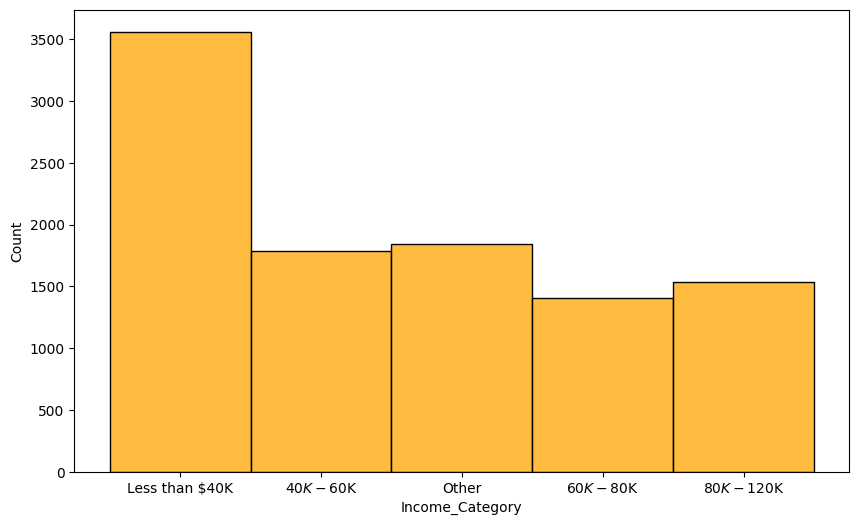

In [43]:
f,ax=plt.subplots(figsize = (10,6))
ax = sns.histplot(x = "Income_Category", data = data,color = "Orange")
plt.show()
#grafic pentru "Income Category"

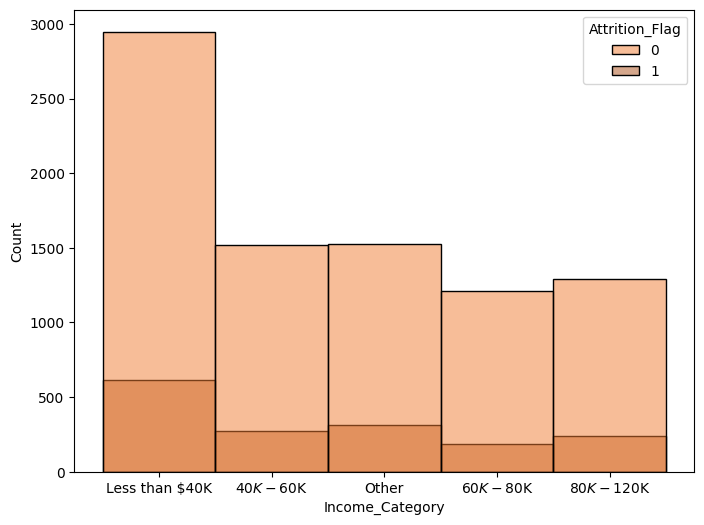

In [44]:
f,ax=plt.subplots(figsize = (8,6))
ax = sns.histplot(x = "Income_Category", data = data,palette = "Oranges_d", hue = "Attrition_Flag")
plt.show()
#grafic pentru "Income_Category" in comparatie cu "Attrition_Flag"

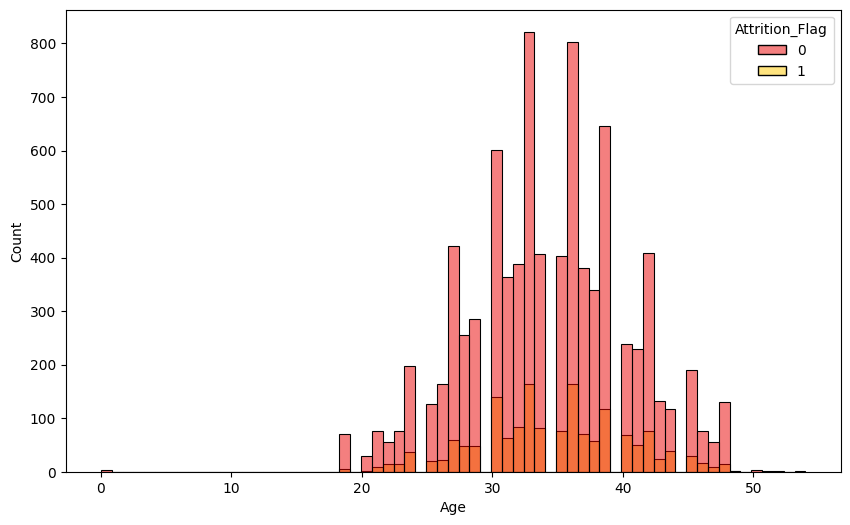

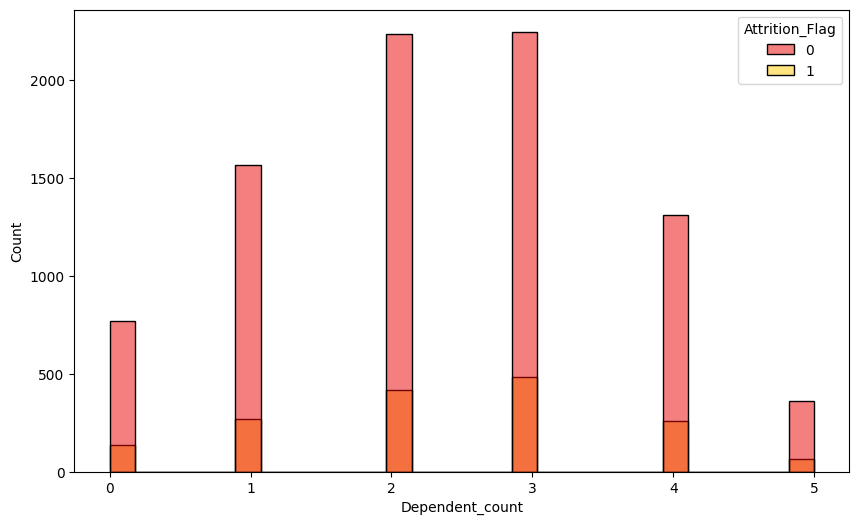

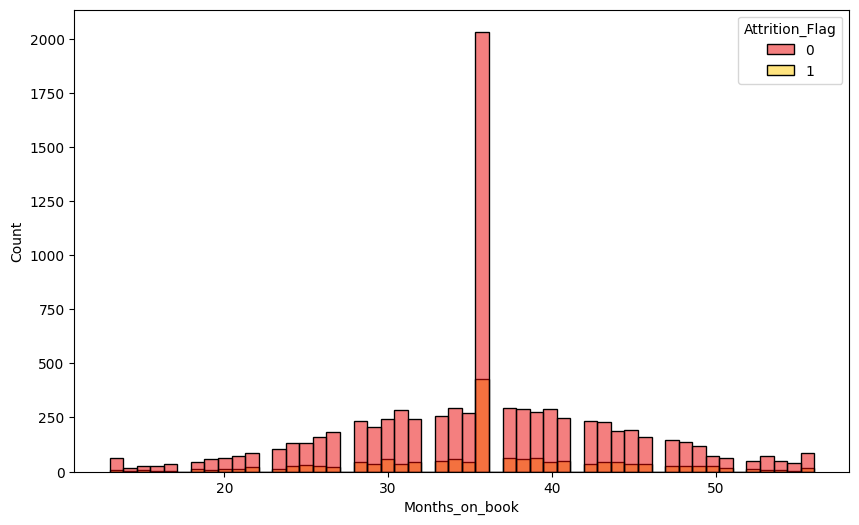

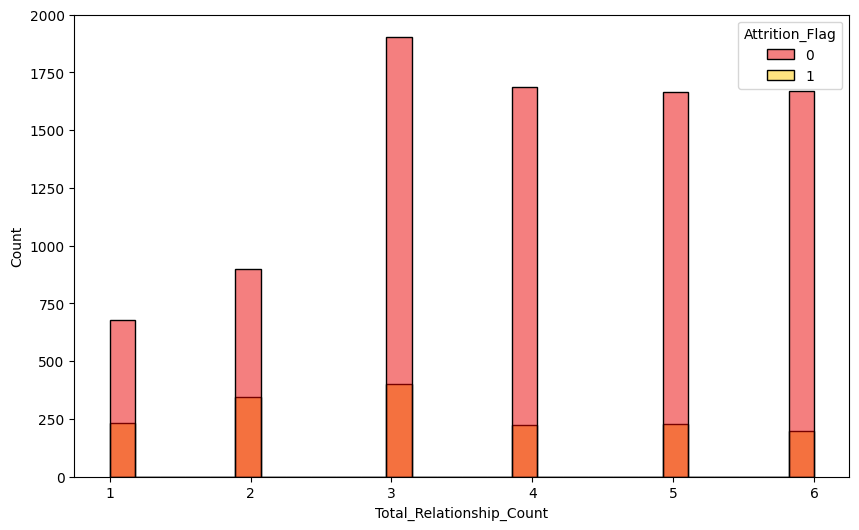

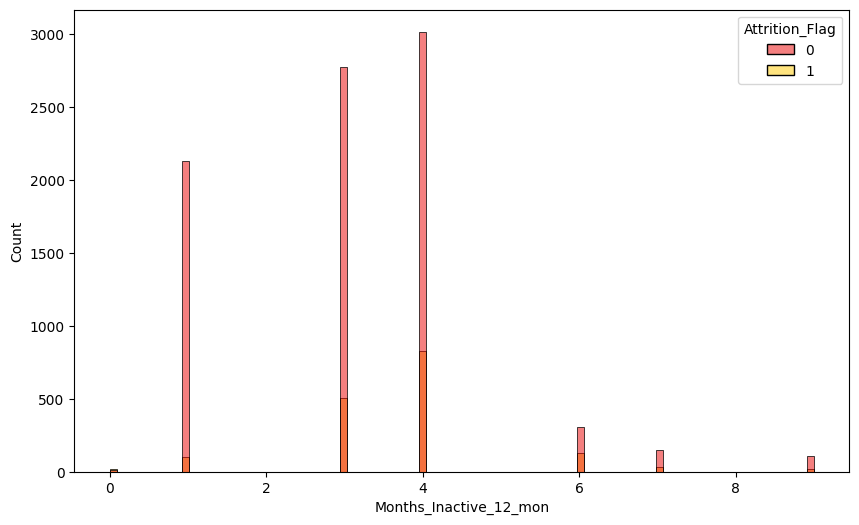

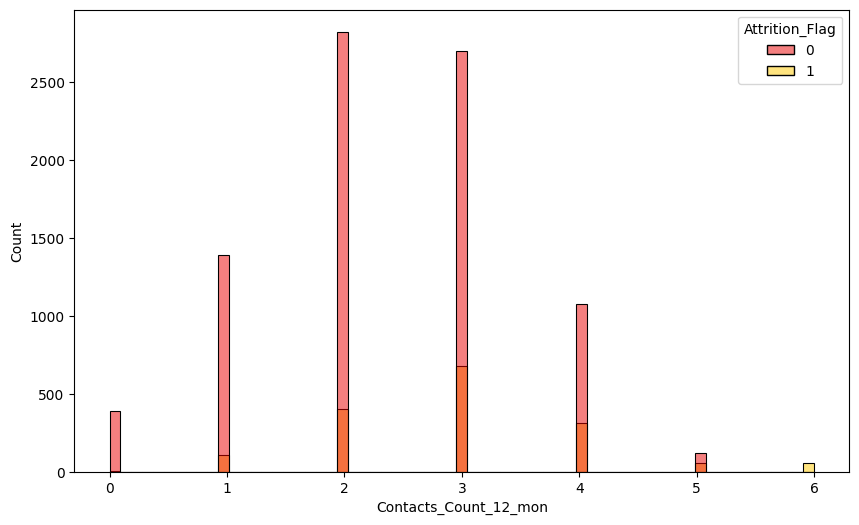

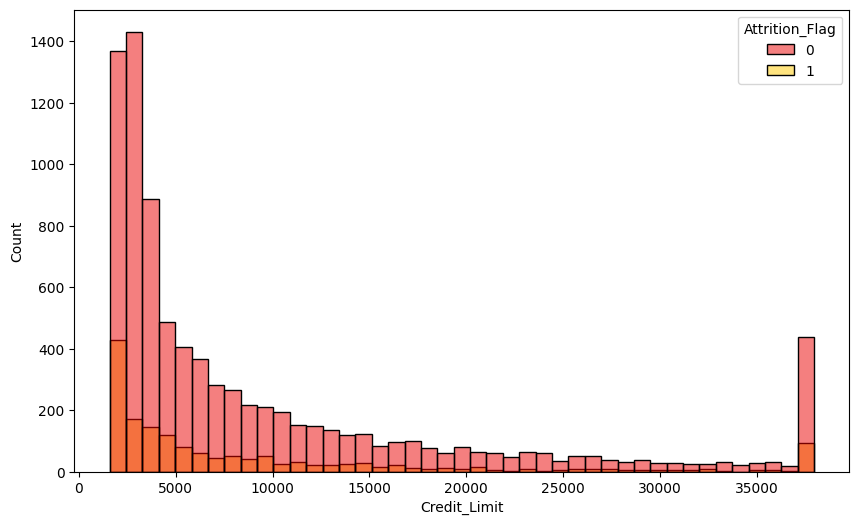

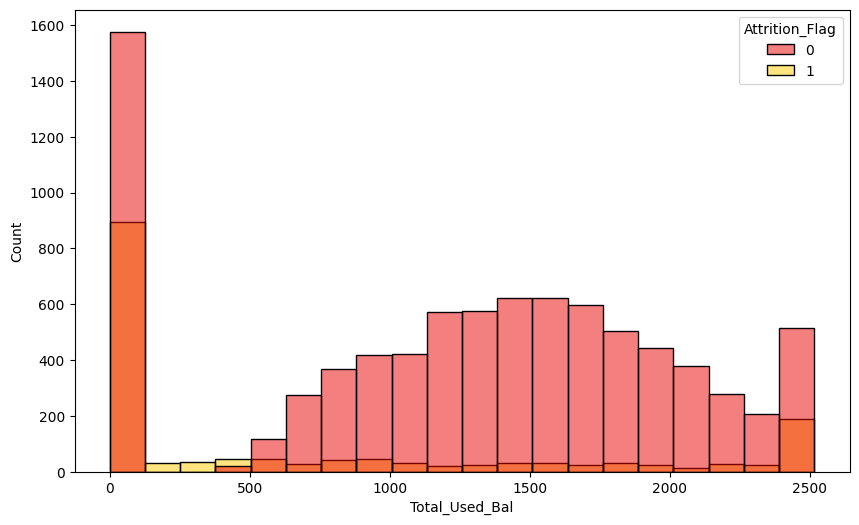

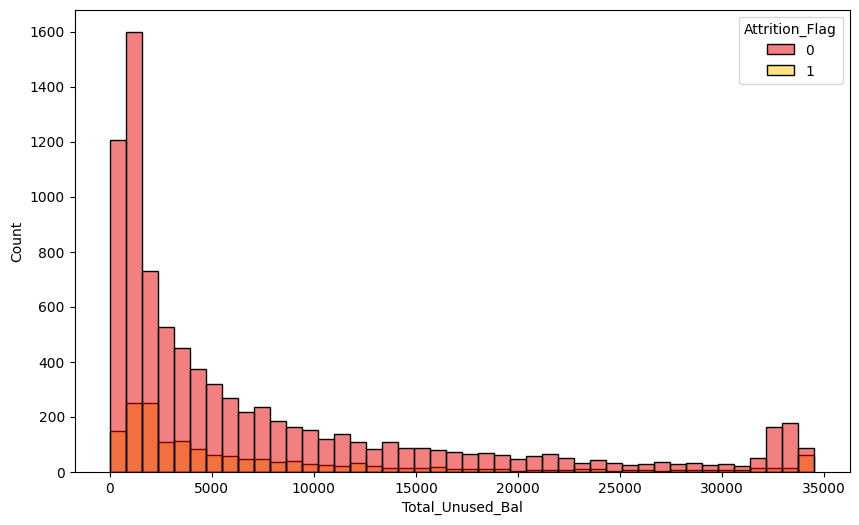

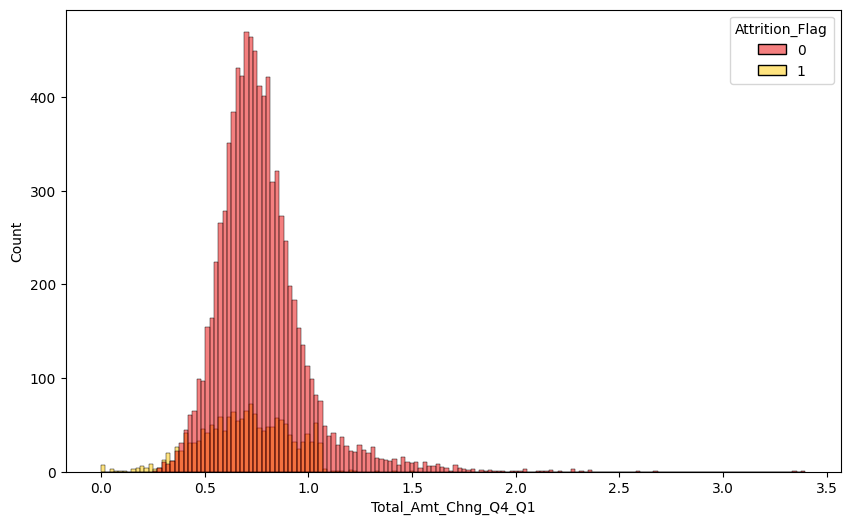

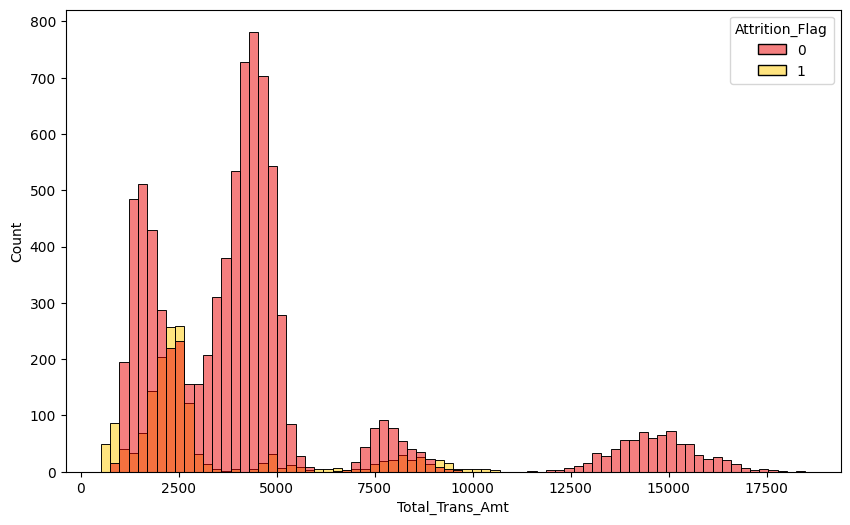

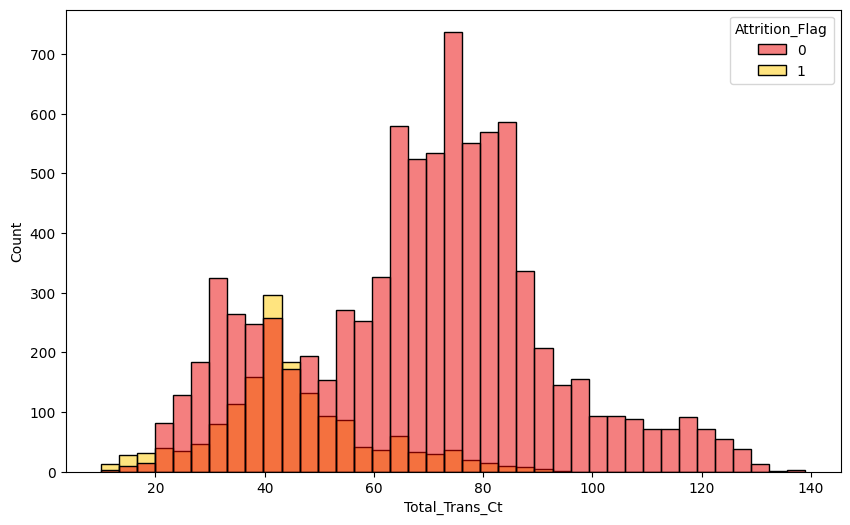

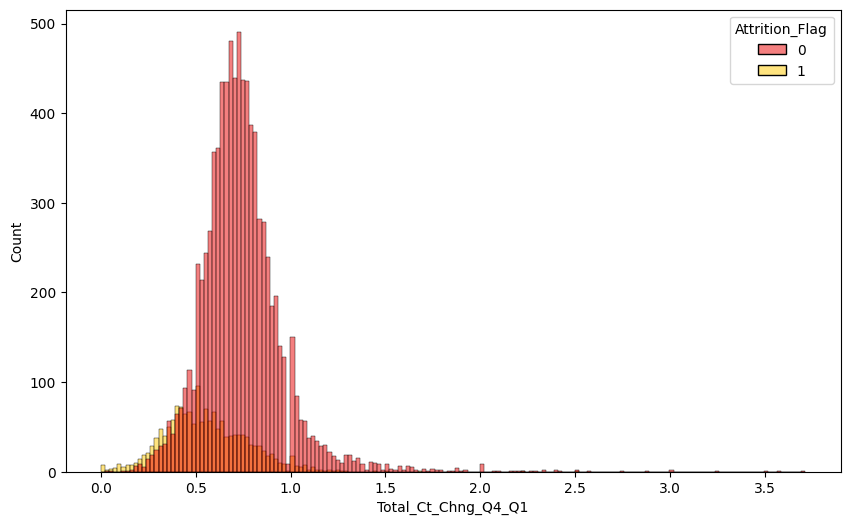

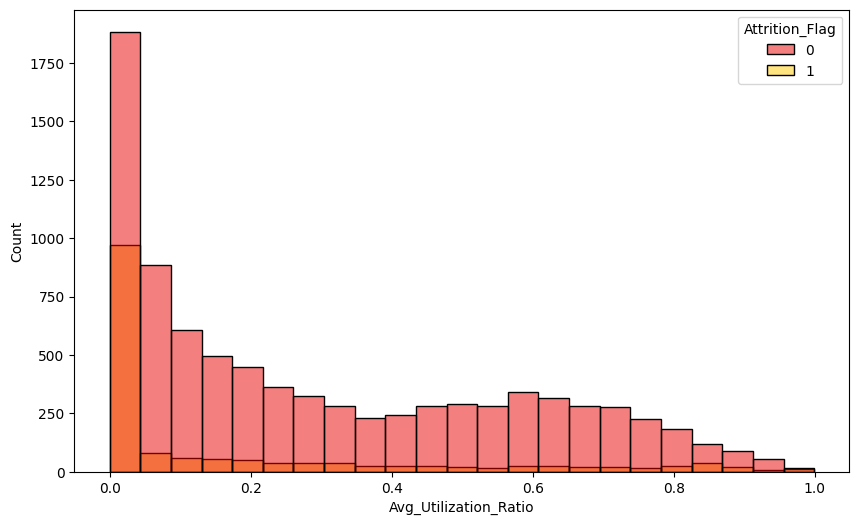

In [45]:
for col in numerical_features:
  f,ax=plt.subplots(figsize = (10,6))
  ax = sns.histplot(x = col, data = data,palette = "hot", hue = "Attrition_Flag")
  plt.show()
  #grafic pentru "Attrition_Flag" in functie de numerical_features

In [46]:
data[numerical_features].isnull().sum()

Age                         0
Dependent_count             5
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Used_Bal              0
Total_Unused_Bal            0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [47]:
data["Dependent_count"] = data["Dependent_count"].fillna(0)

In [48]:
data["Dependent_count"].isnull().sum()

0

In [49]:
data[numerical_features].nunique()

Age                           36
Dependent_count                6
Months_on_book                44
Total_Relationship_Count       6
Months_Inactive_12_mon         7
Contacts_Count_12_mon          7
Credit_Limit                6205
Total_Used_Bal              1974
Total_Unused_Bal            6813
Total_Amt_Chng_Q4_Q1        1158
Total_Trans_Amt             5033
Total_Trans_Ct               126
Total_Ct_Chng_Q4_Q1          830
Avg_Utilization_Ratio        964
dtype: int64

In [50]:
variance = [[column, np.var(data[column])] for column in numerical_features]
variance
#am afisat varianta dintre numerical_features

[['Age', 36.5263982223822],
 ['Dependent_count', 1.6888777266544448],
 ['Months_on_book', 63.776547513800956],
 ['Total_Relationship_Count', 2.4159452235175527],
 ['Months_Inactive_12_mon', 2.3550310289110072],
 ['Contacts_Count_12_mon', 1.2236132274454317],
 ['Credit_Limit', 99943221.84646627],
 ['Total_Used_Bal', 664138.7691199421],
 ['Total_Unused_Bal', 82632399.23550607],
 ['Total_Amt_Chng_Q4_Q1', 0.04804686277603165],
 ['Total_Trans_Amt', 11539347.589273265],
 ['Total_Trans_Ct', 550.9071582840261],
 ['Total_Ct_Chng_Q4_Q1', 0.05667938947463588],
 ['Avg_Utilization_Ratio', 0.07599828095674321]]

In [51]:
q1 = data["Total_Trans_Amt"].quantile(0.25)
q3 = data["Total_Trans_Amt"].quantile(0.75)

In [52]:
iqr = q3 - q1

In [53]:
lower_limit = q1-3*iqr

In [54]:
upper_limit = q3+3*iqr

In [55]:
data[(data["Total_Trans_Amt"] < lower_limit)|(data["Total_Trans_Amt"] > upper_limit)]["Total_Trans_Amt"]
#am aflat limitele inferioare si superioare cu ajutorul cuartilelor

103     14716
104     14330
105     13355
106     16730
107     13563
        ...  
9806    12980
9807    13722
9808    14463
9809    15802
9810    15075
Name: Total_Trans_Amt, Length: 737, dtype: int64

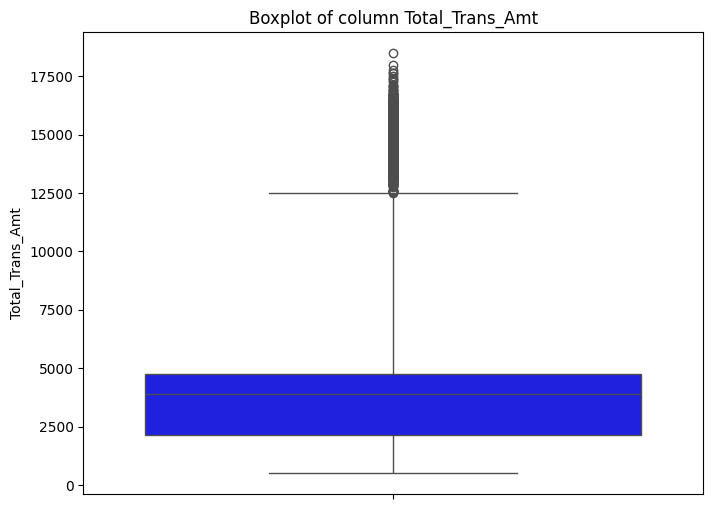

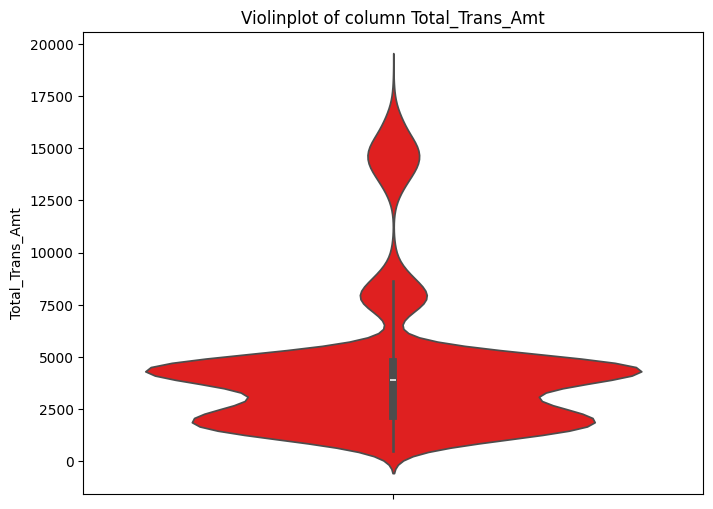

In [56]:
figure,axes = plt.subplots(figsize = (8,6))
sns.boxplot(y=data["Total_Trans_Amt"],color = "blue",whis = 3)
plt.title("Boxplot of column Total_Trans_Amt")
plt.show()

figure,axes = plt.subplots(figsize = (8,6))
sns.violinplot(y=data["Total_Trans_Amt"],color = "red")
plt.title("Violinplot of column Total_Trans_Amt")
plt.show()

In [57]:
def find_outliers(dataframe, column):
  q1 = dataframe[column].quantile(0.25)
  q3 = dataframe[column].quantile(0.75)
  iqr = q3 - q1
  lower_limit = q1-3*iqr
  upper_limit = q3+3*iqr
  outliers = dataframe[(dataframe[column] < lower_limit)|(dataframe[column] > upper_limit)][column]
  return len(outliers)
  #am facut o functie pentru a gasi valorile extreme

In [58]:
columns_with_outliers= [col for col in numerical_features if find_outliers(data,col)>0]
#coloanele cu valori extreme

In [59]:
find_outliers(data,"Total_Trans_Amt")
#nr de valori extreme din "Total_Trans_Amt"

737

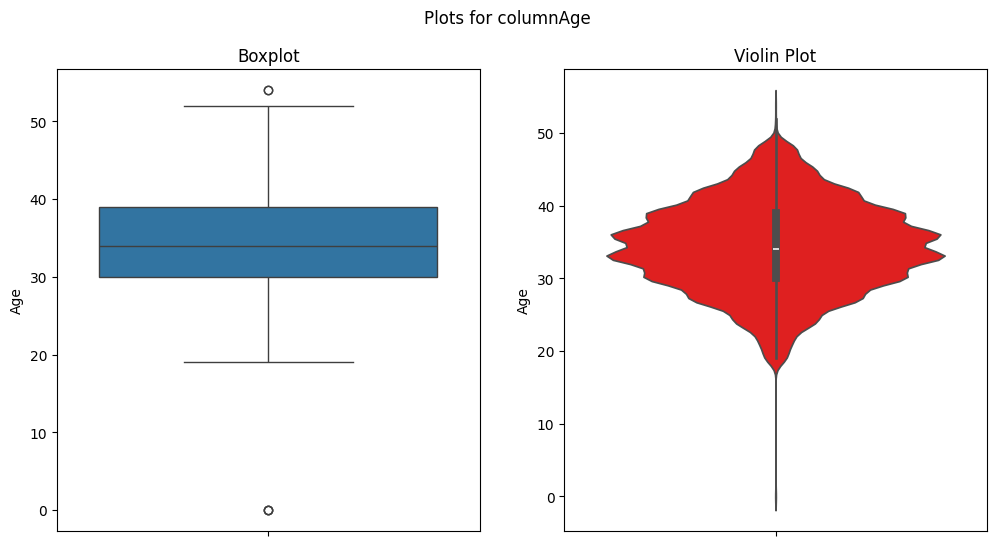

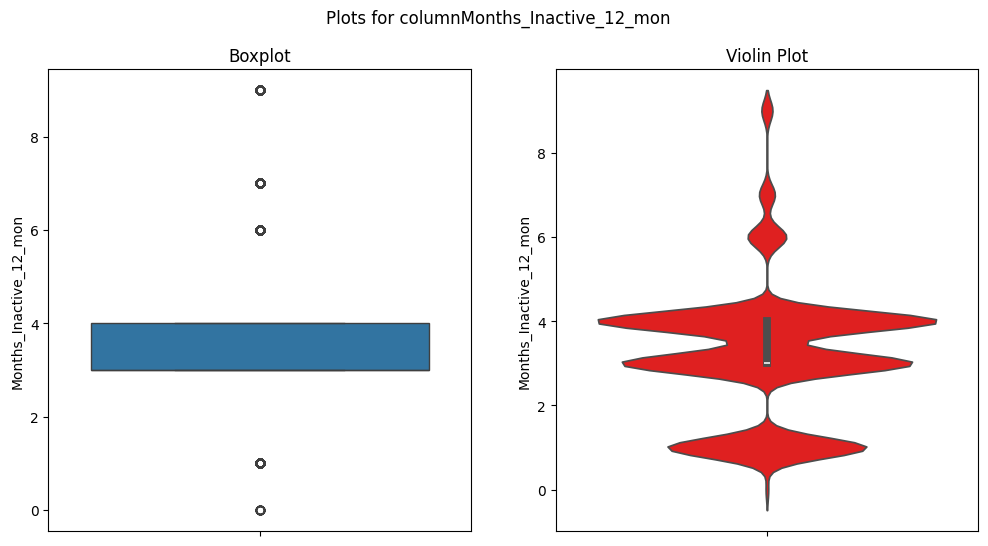

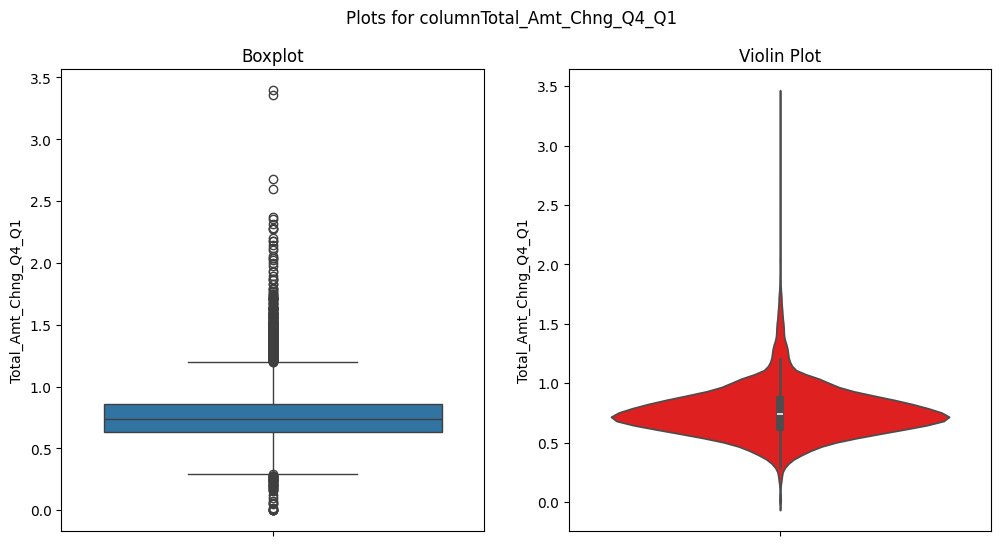

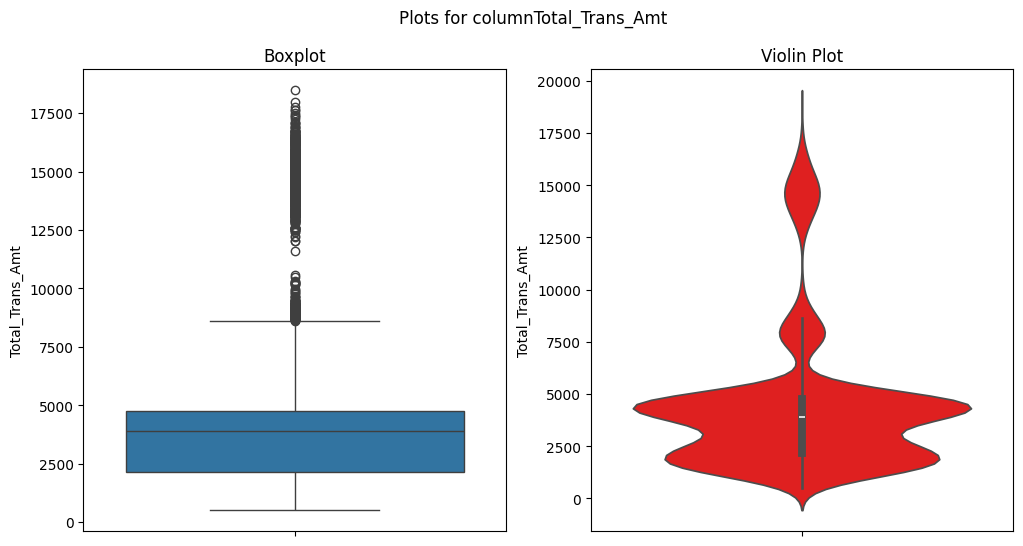

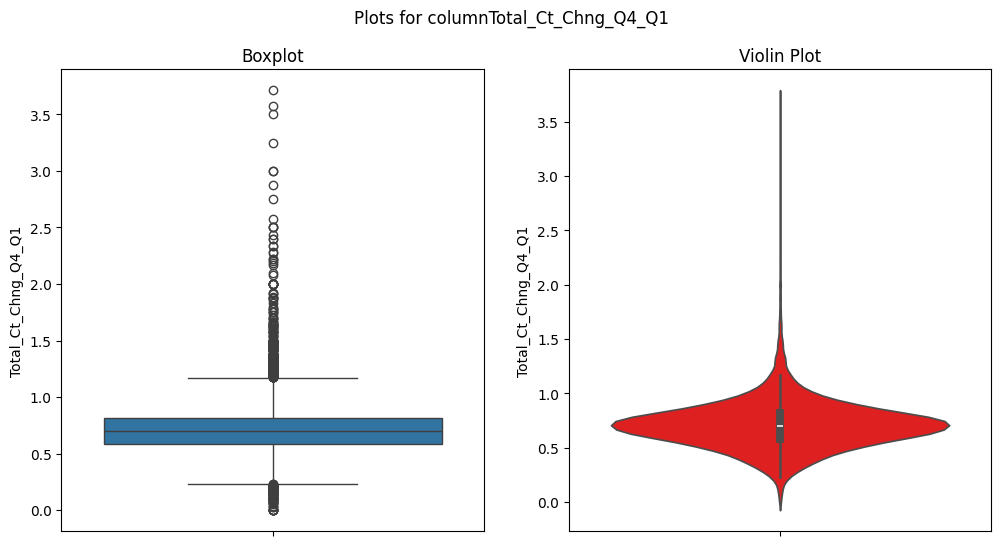

In [60]:
for col in columns_with_outliers:
  figure, axes = plt.subplots(figsize=(12,6), nrows = 1, ncols = 2)
  plt.suptitle("Plots for column" + str(col))

  sns.boxplot(y = data[col],ax = axes[0])
  axes[0].set_title("Boxplot")

  sns.violinplot(y = data[col],color = "red", ax=axes[1])
  axes[1].set_title("Violin Plot")

  plt.show()


In [61]:
affected_variable = ["Total_Trans_Amt"]

In [62]:
def censoring_outliers(dataframe, column):
  q1 = dataframe[column].quantile(0.25)
  q3 = dataframe[column].quantile(0.75)
  iqr = q3 - q1
  lower_limit = q1-3*iqr
  upper_limit = q3+3*iqr
  dataframe[column] = np.where(dataframe[column]<lower_limit,lower_limit,
                               np.where(dataframe[column]>upper_limit,
                                        upper_limit,
                                        dataframe[column]))

In [63]:
for variable in affected_variable:
  censoring_outliers(data,variable)
  #am sters valorile extreme din coloanele afectate de varianta mare

In [64]:
correlation = data[numerical_features].corr()

In [65]:
correlation

,Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Used_Bal,Total_Unused_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Age,1.000000,-0.123397,0.784324,-0.012137,0.055808,-0.016156,0.002390,0.014413,0.001097,-0.061337,-0.041917,-0.062463,-0.012149,0.006617
Dependent_count,-0.123397,1.000000,-0.103872,-0.039495,-0.012916,-0.040394,0.068422,-0.003003,0.068676,-0.036151,0.033607,0.052085,0.010755,-0.037256
Months_on_book,0.784324,-0.103872,1.000000,-0.009203,0.074402,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.037315,-0.049819,-0.014072,-0.007541
Total_Relationship_Count,-0.012137,-0.039495,-0.009203,1.000000,-0.002237,0.055203,-0.071386,0.013726,-0.072601,0.050119,-0.359299,-0.241891,0.040831,0.067663
Months_Inactive_12_mon,0.055808,-0.012916,0.074402,-0.002237,1.000000,0.031108,-0.018455,-0.043730,-0.014531,-0.032746,-0.039030,-0.044282,-0.038374,-0.009526
Contacts_Count_12_mon,-0.016156,-0.040394,-0.010774,0.055203,0.031108,1.000000,0.020817,-0.053913,0.025646,-0.024445,-0.122814,-0.152213,-0.094997,-0.055471
Credit_Limit,0.002390,0.068422,0.007507,-0.071386,-0.018455,0.020817,1.000000,0.042493,0.995981,0.012813,0.169344,0.075927,-0.002020,-0.482965
Total_Used_Bal,0.014413,-0.003003,0.008623,0.013726,-0.043730,-0.053913,0.042493,1.000000,-0.047167,0.058174,0.059969,0.056060,0.089861,0.624022
Total_Unused_Bal,0.001097,0.068676,0.006732,-0.072601,-0.014531,0.025646,0.995981,-0.047167,1.000000,0.007595,0.163932,0.070885,-0.010076,-0.538808
Total_Amt_Chng_Q4_Q1,-0.061337,-0.036151,-0.048959,0.050119,-0.032746,-0.024445,0.012813,0.058174,0.007595,1.000000,0.041941,0.005469,0.384189,0.035235


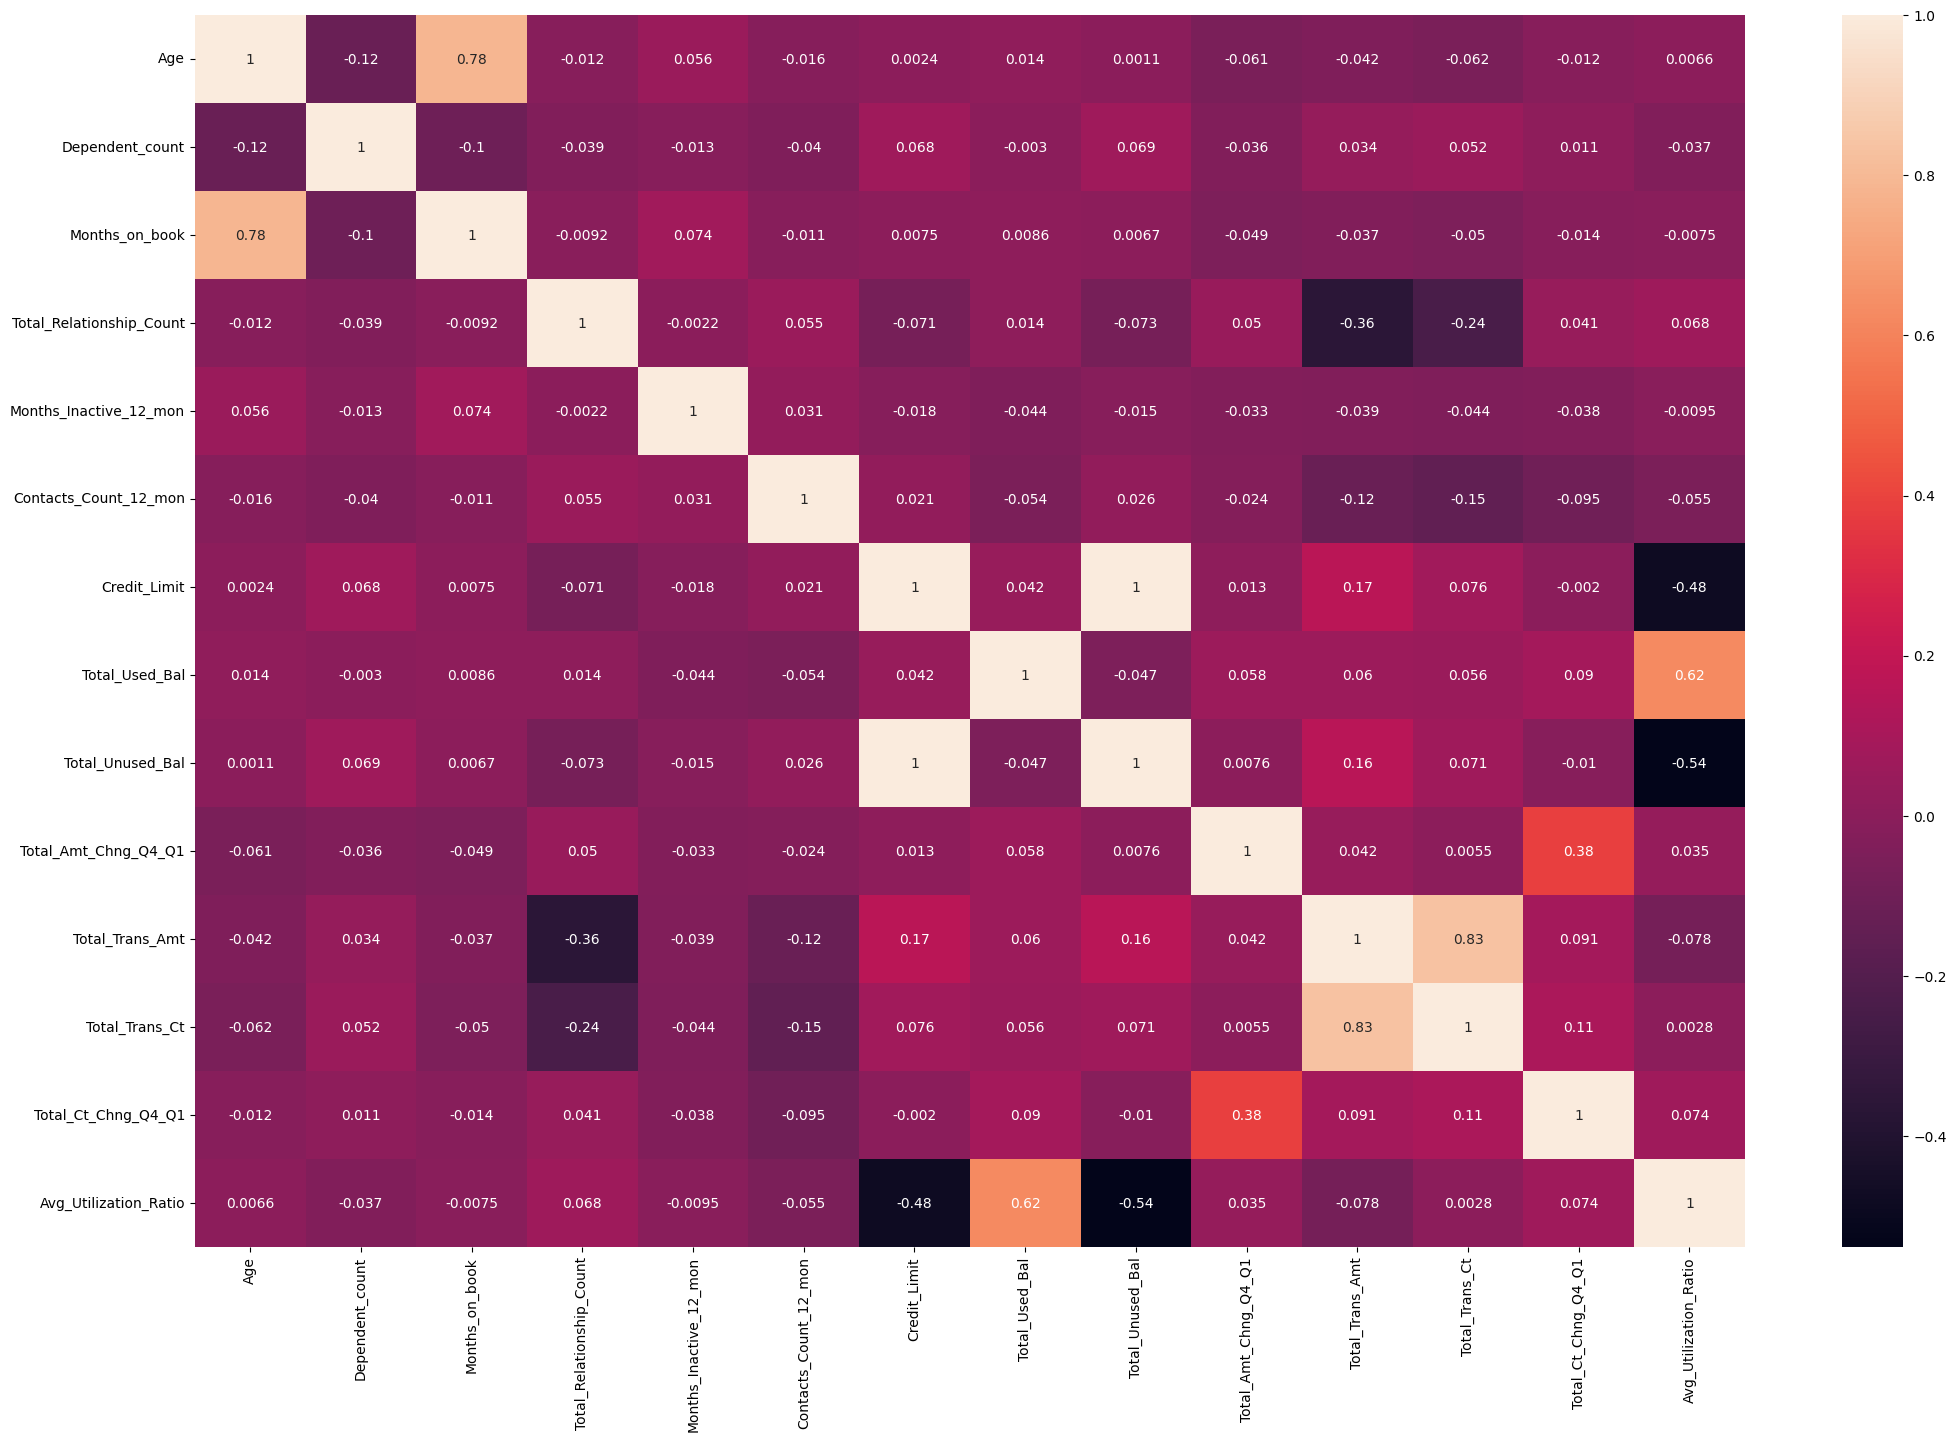

In [66]:
plt.subplots(figsize = (25,16))
sns.heatmap(correlation, annot = True)
plt.show()

In [67]:
columns_to_drop=["Total_Unused_Bal"]
#stergem coloanele cu o corelatie foarte mare

In [68]:
columns_to_drop

['Total_Unused_Bal']

In [69]:
data = data.drop(columns = ["Total_Unused_Bal"])

In [70]:
data.shape

(10127, 20)

In [71]:
x = data.drop(columns = ["Attrition_Flag"])

In [72]:
y = data["Attrition_Flag"]

In [73]:
x.shape

(10127, 19)

In [74]:
x = x.drop(columns = ["ID"])

In [75]:
categorical_columns = [col for col in x.columns if x[col].dtypes == "object"]

In [76]:
categorical_columns

['Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

In [77]:
x = pd.get_dummies(x, columns = categorical_columns)

In [78]:
x.columns

Index(['Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
       'Total_Used_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender_F', 'Gender_M', 'Education_Level_College',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Other',
       'Education_Level_Post-Graduate', 'Education_Level_Uneducated',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K',
       'Income_Category_$80K - $120K', 'Income_Category_Less than $40K',
       'Income_Category_Other', 'Card_Category_Blue', 'Card_Category_Gold',
       'Card_Category_Green', 'Card_Category_Platinum', 'Card_Category_Purple',
       'Card_Category_Silver'],
   

In [79]:
columns_to_drop = ["Gender_F",
"Education_Level_Other",
"Marital_Status_Unknown",
"Income_Category_Other",
"Card_Category_Platinum"
"Card_Category_Green"
"Card_Category_Purple"]
#stergem coloanele ce nu ne dau informatii utile pentru procesul de testare (Daca cineva nu este Gender_M, stim ca va fi Gender_F)

In [80]:
x = x.drop(columns=columns_to_drop)

In [81]:
x.shape

(10127, 32)

In [82]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.6, random_state = 12345)
#incepem testele si trainurile

In [83]:
x_train.shape, y_train.shape,x_test.shape, y_test.shape

((4050, 32), (4050,), (6077, 32), (6077,))

In [84]:
rf = RandomForestClassifier()
#incepem algoritmul de invatare automata supervizata

In [85]:
rf = RandomForestClassifier(max_depth = 8,n_estimators = 300,n_jobs = -1)

In [86]:
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=8, n_estimators=300, n_jobs=-1)

In [139]:
y_predict = rf.predict(x_test)
#facem o predictie pentru x_test ce ne va da 1 si 0 unde 1 este "Attrited Customer" si 0 este "Existing customer"

In [142]:
y_predict[:300]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [89]:
cm = confusion_matrix(y_test,y_predict)
#creem matricea de confuzie pentru a afla acuratetea, precizia si recall-ul

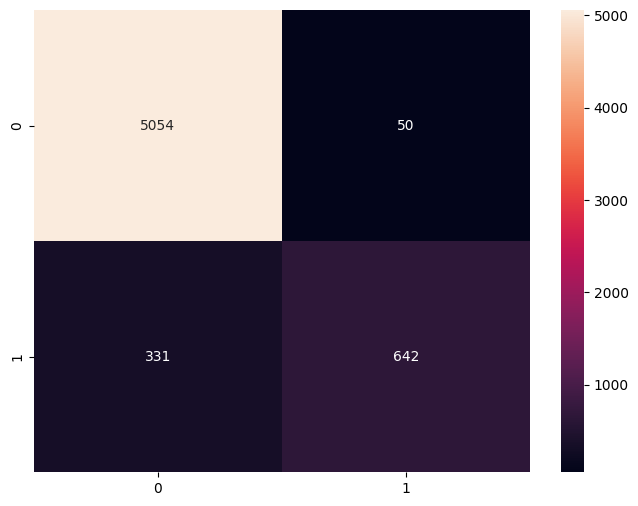

In [90]:
fig,ax = plt.subplots(figsize = (8,6))
sns.heatmap(cm,annot = True,fmt = "d")
plt.show()

In [91]:
accuracy_test = accuracy_score(y_test, y_predict)
precision_test = precision_score(y_test, y_predict)
recall_test = recall_score(y_test, y_predict)
print("Accuracy for the test is:",accuracy_test)
print("Precision for the test is:",precision_test)
print("Recall for the test is:",recall_test)

Accuracy for the test is: 0.9373045910811255
Precision for the test is: 0.9277456647398844
Recall for the test is: 0.6598150051387461


In [92]:
roc_auc_test = roc_auc_score(y_test,y_predict)
print("AUC for the test is", roc_auc_test)
#facem testul AUC (aria de sub curba)

AUC for the test is 0.8250093834471159


In [93]:
y_predict_train = rf.predict(x_train)
#facem o predictie si pentru train

In [94]:
accuracy_train = accuracy_score(y_train, y_predict_train)
precision_train = precision_score(y_train, y_predict_train)
recall_train = recall_score(y_train, y_predict_train)
print("Accuracy for the train is:",accuracy_train)
print("Precision for the train is:",precision_train)
print("Recall for the train is:",recall_train)

Accuracy for the train is: 0.9649382716049383
Precision for the train is: 0.9848484848484849
Recall for the train is: 0.7951070336391437


In [95]:
roc_auc_train = roc_auc_score(y_train,y_predict_train)
print("AUC for the test is", roc_auc_train)

AUC for the test is 0.8963756605180406


In [96]:
lgbm= LGBMClassifier(n_estimators = 300,max_depth = 8, learning_rate = 0.1,n_jobs = -1,verbose = -1, random_state = 10)
#ne folosim de seturi secventiale prin lgbm

In [97]:
lgbm.fit(x_train,y_train)

LGBMClassifier(max_depth=8, n_estimators=300, n_jobs=-1, random_state=10,
               verbose=-1)

In [98]:
y_predict_lgbm = lgbm.predict(x_test)

In [99]:
accuracy_lgbm = accuracy_score(y_test, y_predict_lgbm)
print("Accuracy for LGBM test is:",accuracy_lgbm)

Accuracy for LGBM test is: 0.9712028961658713


In [100]:
precision_lgbm = precision_score(y_test, y_predict_lgbm)
print("Precision for LGBM test is:",precision_lgbm)
recall_lgbm = recall_score(y_test, y_predict_lgbm)
print("Recall for LGBM test is:",recall_lgbm)

Precision for LGBM test is: 0.9281115879828327
Recall for LGBM test is: 0.8890030832476875


In [101]:
cm_lgbm = confusion_matrix(y_test, y_predict_lgbm)

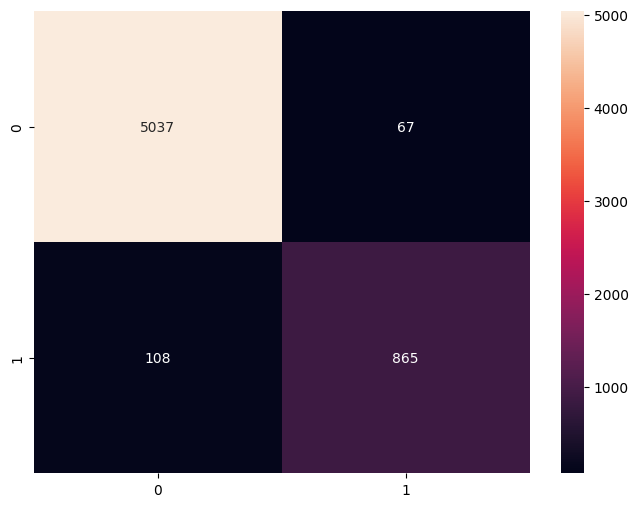

In [102]:
fig,ax = plt.subplots(figsize = (8,6))
sns.heatmap(cm_lgbm,annot = True,fmt = "d")
plt.show()

In [103]:
roc_auc_lgbm = roc_auc_score(y_test, y_predict_lgbm)
print(roc_auc_lgbm)

0.9379380620000193


In [104]:
y_predict_train = lgbm.predict(x_train)

In [105]:
accuracy_train = accuracy_score(y_train, y_predict_train)
precision_train = precision_score(y_train, y_predict_train)
recall_train = recall_score(y_train, y_predict_train)
print("Accuracy for the train is:",accuracy_train)
print("Precision for the train is:",precision_train)
print("Recall for the train is:",recall_train)

Accuracy for the train is: 1.0
Precision for the train is: 1.0
Recall for the train is: 1.0


In [106]:
roc_auc_lgbm = roc_auc_score(y_train, y_predict_train)
print(roc_auc_lgbm)

1.0


In [107]:
preds_prob = lgbm.predict_proba(x_test)

In [108]:
preds_prob

array([[9.99998865e-01, 1.13508636e-06],
       [9.99997513e-01, 2.48686831e-06],
       [9.99994007e-01, 5.99268296e-06],
       ...,
       [6.69994860e-09, 9.99999993e-01],
       [9.99996363e-01, 3.63744992e-06],
       [9.99999993e-01, 7.03288011e-09]])

In [109]:
roc_auc = roc_auc_score(y_test, preds_prob[:,1])

In [110]:
print(roc_auc)

0.9918468718084199


In [111]:
n_estimators = [1200,800,500,200]
max_depths = [10,6,4]
learning_rates = [0.3,0.2,0.1,0.01]

In [112]:
results = []
for est in n_estimators:
  for md in max_depths:
    for lr in learning_rates:
      lgbm = LGBMClassifier(n_estimators = est,
                            max_depth=md,
                            learning_rate=lr,
                            n_jobs = -1,
                            verbose = -1,
                            random_state = 10,
                            subsample = 0.6,
                            colsample_bytree = 0.5)
      lgbm.fit(x_train, y_train)
      y_predict_train = lgbm.predict_proba(x_train)[:,1]
      y_predict_test = lgbm.predict_proba(x_test)[:,1]
      auc_score_train = roc_auc_score(y_train, y_predict_train)
      auc_score_test = roc_auc_score(y_test, y_predict_test)
      results.append({"n_estimators":est,
                      "max_depth":md,
                      "learning_rate" : lr,
                      "auc_train":auc_score_train,
                      "auc_test":auc_score_test,
                      "auc_diff":auc_score_train-auc_score_test})
results_df = pd.DataFrame(results)
#facem tuning pentru a afla rezultate pentru mai multe tipuri de parametrii

In [113]:
results_df

,n_estimators,max_depth,learning_rate,auc_train,auc_test,auc_diff
0,1200,10,0.30,1.000000,0.991368,0.008632
1,1200,10,0.20,1.000000,0.991946,0.008054
2,1200,10,0.10,1.000000,0.992031,0.007969
3,1200,10,0.01,1.000000,0.992535,0.007465
4,1200,6,0.30,1.000000,0.991161,0.008839
5,1200,6,0.20,1.000000,0.991261,0.008739
6,1200,6,0.10,1.000000,0.991847,0.008153
7,1200,6,0.01,0.999999,0.992206,0.007793
8,1200,4,0.30,1.000000,0.990772,0.009228
9,1200,4,0.20,1.000000,0.990607,0.009393


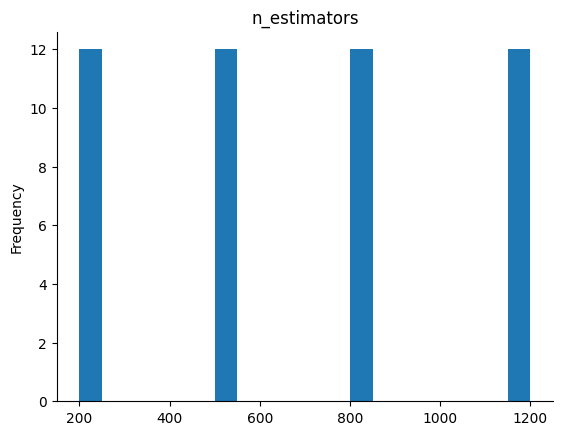

In [114]:
# @title n_estimators

from matplotlib import pyplot as plt
results_df['n_estimators'].plot(kind='hist', bins=20, title='n_estimators')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [115]:
results_df.sort_values(by = "auc_test", ascending = False).head(10)
#sortam valorile descrescator in fucntie de auc_test

,n_estimators,max_depth,learning_rate,auc_train,auc_test,auc_diff
3,1200,10,0.01,1.000000,0.992535,0.007465
15,800,10,0.01,1.000000,0.992465,0.007535
42,200,6,0.10,1.000000,0.992415,0.007585
7,1200,6,0.01,0.999999,0.992206,0.007793
38,200,10,0.10,1.000000,0.992170,0.007830
14,800,10,0.10,1.000000,0.992159,0.007841
26,500,10,0.10,1.000000,0.992101,0.007899
30,500,6,0.10,1.000000,0.992099,0.007901
2,1200,10,0.10,1.000000,0.992031,0.007969
25,500,10,0.20,1.000000,0.991988,0.008012


In [116]:
lgbm_final = LGBMClassifier(n_estimators = 600,
                        max_depth=8,
                        learning_rate=0.01,
                        n_jobs = -1,
                        verbose = -1,
                        random_state = 10,
                        subsample = 0.5,
                        colsample_bytree = 0.5,
                        importance_type = "gain")
lgbm_final.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.5, importance_type='gain', learning_rate=0.01,
               max_depth=8, n_estimators=600, n_jobs=-1, random_state=10,
               subsample=0.5, verbose=-1)

In [117]:
y_predict_proba=lgbm_final.predict_proba(x_test)
y_predict_proba_class_1 = y_predict_proba[:,1]

In [118]:
y_predict_proba_class_1

array([0.01136642, 0.01007351, 0.01190515, ..., 0.98846491, 0.01190646,
       0.0015522 ])

In [119]:
roc_auc = roc_auc_score(y_test,y_predict_proba_class_1)
print(roc_auc)

0.9920176263825481


In [120]:
def create_gain_lift_report(y_test,y_predict_probs):
  lift_gain_report = pd.DataFrame()

  lift_gain_report["y_test"] = y_test
  lift_gain_report["Predicted Probabilities"] = y_predict_probs

  lift_gain_report = lift_gain_report.sort_values(by = "Predicted Probabilities", ascending = False, ignore_index = True)
  lift_gain_report ["Decile Group"] = pd.qcut(lift_gain_report["Predicted Probabilities"],q=10,labels = [10,9,8,7,6,5,4,3,2,1])
  lift_gain_report["Decile Group"] = pd.to_numeric(lift_gain_report["Decile Group"])
  lift_gain_report["Number of obs"] = 1
  lift_gain_report = lift_gain_report.groupby(["Decile Group"]).sum().reset_index()

  lift_gain_report["Cumulative no of obs"] = lift_gain_report["Number of obs"].cumsum()
  lift_gain_report["Cumulative % of obs"] = lift_gain_report["Cumulative no of obs"]/lift_gain_report["Cumulative no of obs"].max()
  lift_gain_report["Cumulative no of pos"] = lift_gain_report["y_test"].cumsum()
  lift_gain_report["Gain"] = lift_gain_report["Cumulative no of pos"]/lift_gain_report["Cumulative no of pos"].max()
  lift_gain_report["Lift"] = lift_gain_report["Gain"]/ lift_gain_report["Cumulative % of obs"]

  return lift_gain_report

lift_gain_report = create_gain_lift_report(y_test,y_predict_proba_class_1)
lift_gain_report
#calculam lift-ul si gain-ul

,Decile Group,y_test,Predicted Probabilities,Number of obs,Cumulative no of obs,Cumulative % of obs,Cumulative no of pos,Gain,Lift
0,1,596,575.693756,608,608,0.100049,596,0.612539,6.122363
1,2,343,302.624424,608,1216,0.200099,939,0.965057,4.822902
2,3,29,43.403304,607,1823,0.299984,968,0.994861,3.316386
3,4,3,12.009278,608,2431,0.400033,971,0.997945,2.494656
4,5,1,5.442776,607,3038,0.499918,972,0.998972,1.998273
5,6,1,3.093835,608,3646,0.599967,973,1.000000,1.666758
6,7,0,2.048974,608,4254,0.700016,973,1.000000,1.428538
7,8,0,1.443938,607,4861,0.799901,973,1.000000,1.250154
8,9,0,1.066239,608,5469,0.899951,973,1.000000,1.111172
9,10,0,0.751257,608,6077,1.000000,973,1.000000,1.000000


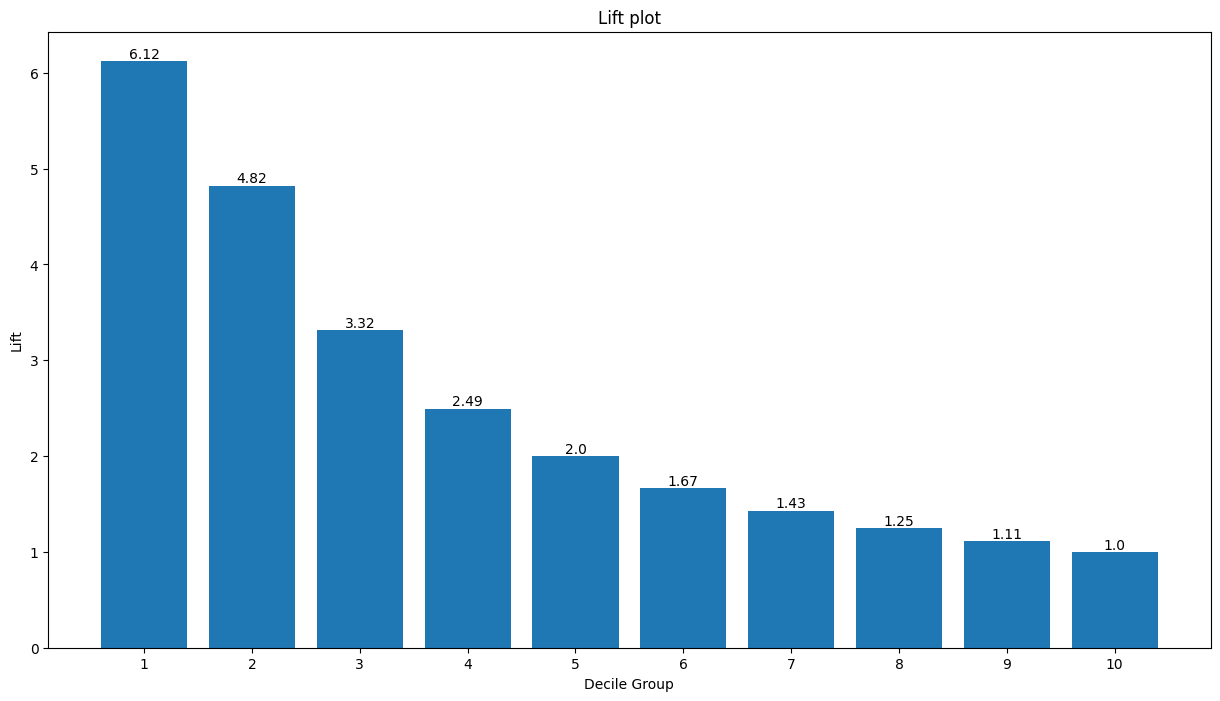

In [121]:
fig,ax = plt.subplots(figsize = (15,8))
barplot = ax.bar(lift_gain_report["Decile Group"],lift_gain_report["Lift"])
plt.title("Lift plot")
plt.xlabel("Decile Group")
plt.ylabel("Lift")
plt.xticks(lift_gain_report["Decile Group"])
ax.bar_label(barplot,labels = np.round(lift_gain_report["Lift"],2).values,label_type = "edge")
plt.show()

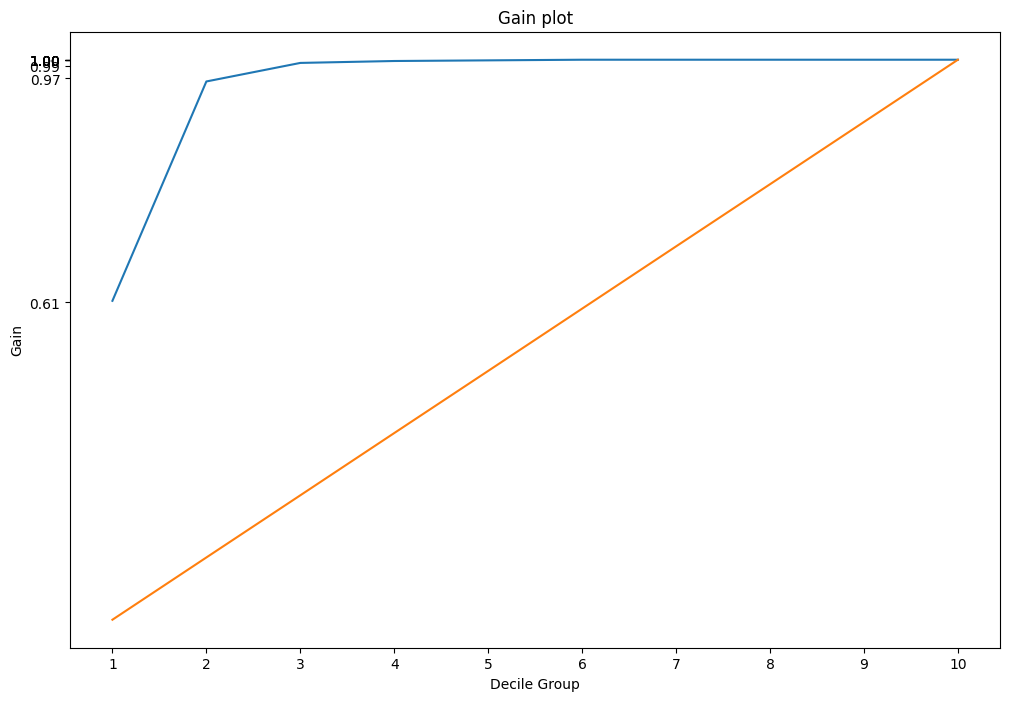

In [122]:
fig,ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = lift_gain_report,x = lift_gain_report["Decile Group"], y = lift_gain_report["Gain"])
sns.lineplot(data = lift_gain_report,x = lift_gain_report["Decile Group"], y = lift_gain_report["Cumulative % of obs"])
plt.title("Gain plot")
plt.xticks(lift_gain_report["Decile Group"])
plt.yticks(round(lift_gain_report["Gain"],2))
plt.show()


In [123]:
gain_importance = lgbm_final.feature_importances_

In [124]:
gain_importance

array([4.98659551e+03, 7.12424036e+02, 2.21914882e+03, 1.27222699e+04,
       4.18621715e+03, 3.17305475e+03, 4.67408604e+03, 1.50499855e+04,
       1.14050790e+04, 3.92634667e+04, 4.34881168e+04, 1.53219416e+04,
       6.24909753e+03, 7.24826061e+02, 2.21554704e+02, 1.36318399e+01,
       1.05915282e+02, 7.18397061e+01, 3.47979262e+01, 9.73077461e+01,
       5.59115136e+01, 7.18296987e+02, 2.89764668e+02, 3.87335851e+01,
       7.42013721e+01, 1.32862687e+02, 2.32767440e+02, 8.45369224e+01,
       8.60322517e+00, 0.00000000e+00, 0.00000000e+00, 5.38951589e+01])

In [125]:
feature_names = x_train.columns
feature_importance = pd.DataFrame({"feature":feature_names,
                                   "gain importance":gain_importance})
feature_importance ["% Importance"] = feature_importance["gain importance"].values/ feature_importance["gain importance"].values.sum() * 100
feature_importance.sort_values(by = ["gain importance"], ascending = False)
feature_importance
#aflam importanta pe care a avut-o fiecare variabila pentru rezulvatul la care am ajuns

,feature,gain importance,% Importance
0,Age,4986.595514,2.996555
1,Dependent_count,712.424036,0.428111
2,Months_on_book,2219.148819,1.333535
3,Total_Relationship_Count,12722.269938,7.645093
4,Months_Inactive_12_mon,4186.217147,2.515590
5,Contacts_Count_12_mon,3173.054750,1.906759
6,Credit_Limit,4674.086039,2.808761
7,Total_Used_Bal,15049.985529,9.043868
8,Total_Amt_Chng_Q4_Q1,11405.078971,6.853564
9,Total_Trans_Amt,39263.466687,23.594284


In [126]:
explainer = shap.TreeExplainer(lgbm_final)
shap_values = explainer.shap_values(x_test)
#cu shap reproducem ce a prezis modelul nostru

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


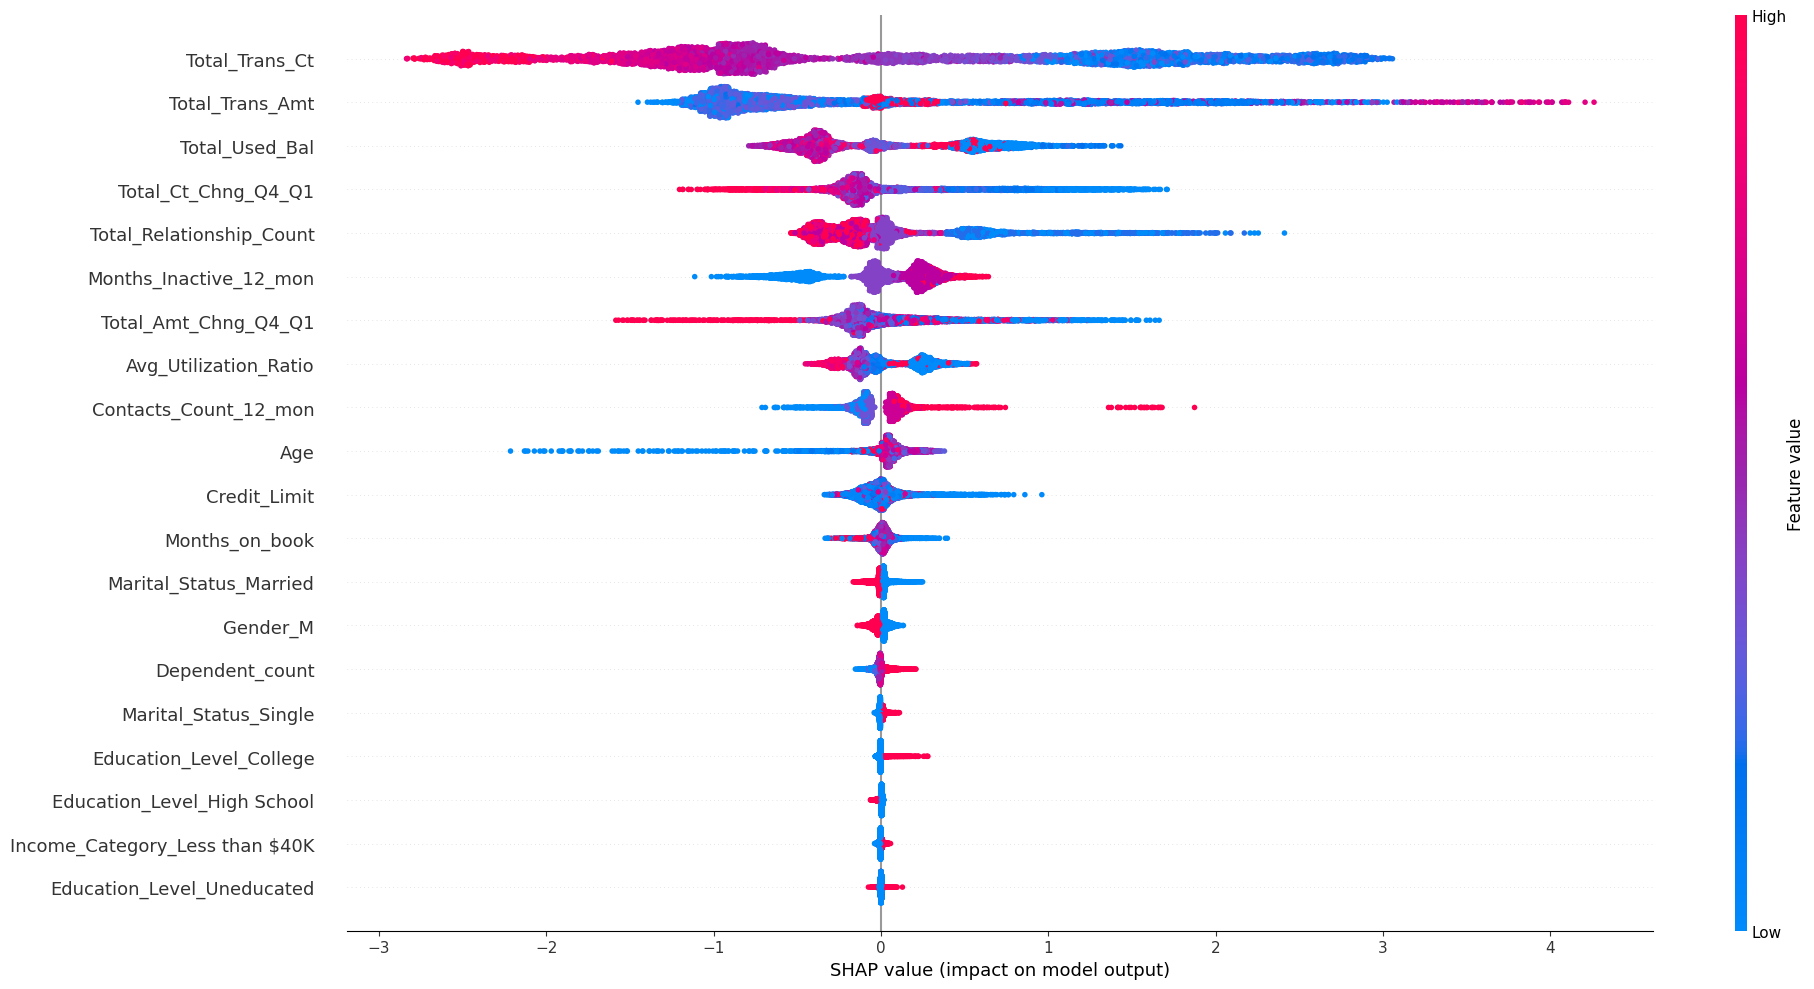

In [127]:
shap.summary_plot(shap_values,x_test,plot_size = (20,10))

In [128]:
feature_importance

,feature,gain importance,% Importance
0,Age,4986.595514,2.996555
1,Dependent_count,712.424036,0.428111
2,Months_on_book,2219.148819,1.333535
3,Total_Relationship_Count,12722.269938,7.645093
4,Months_Inactive_12_mon,4186.217147,2.515590
5,Contacts_Count_12_mon,3173.054750,1.906759
6,Credit_Limit,4674.086039,2.808761
7,Total_Used_Bal,15049.985529,9.043868
8,Total_Amt_Chng_Q4_Q1,11405.078971,6.853564
9,Total_Trans_Amt,39263.466687,23.594284


In [129]:
index = 1200
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[index],x_test.iloc[index],link = "logit")

In [130]:
pr = pd.DataFrame()
pr["proba"] = y_predict_proba_class_1
pr[pr["proba"]==pr["proba"].max()]
#4426 este clientul cu cea mai mare probabilitate de a fi prezis corect

,proba
4426,0.995222


In [143]:
x_test.iloc[4426]
#informatii despre clientul 4426

Age                                   29
Dependent_count                      2.0
Months_on_book                        26
Total_Relationship_Count               2
Months_Inactive_12_mon                 4
Contacts_Count_12_mon                  4
Credit_Limit                      9796.6
Total_Used_Bal                         0
Total_Amt_Chng_Q4_Q1               0.315
Total_Trans_Amt                    809.0
Total_Trans_Ct                        15
Total_Ct_Chng_Q4_Q1                 0.25
Avg_Utilization_Ratio                0.0
Gender_M                            True
Education_Level_College            False
Education_Level_Doctorate          False
Education_Level_Graduate           False
Education_Level_High School        False
Education_Level_Post-Graduate      False
Education_Level_Uneducated          True
Marital_Status_Divorced            False
Marital_Status_Married              True
Marital_Status_Single              False
Income_Category_$40K - $60K        False
Income_Category_

In [132]:
y_train_preds = lgbm_final.predict_proba(x_train)
y_train_proba_class_1 = y_train_preds[:,1]

In [144]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba_class_1)
gmeans = np.sqrt(tpr * (1-fpr))
index = np.argmax(gmeans)
print("Best Treshold is:",thresholds[index])
#calculam cel mai bun treshold (prag de care trebuie sa trecem)

Best Treshold is: 0.37352406298670554


In [134]:
thresholds.shape

(14,)

In [135]:
gmeans

array([0.        , 0.03910309, 0.9327543 , 0.93261696, 0.94321059,
       0.94307166, 0.98585209, 0.98570685, 0.99649677, 0.99620303,
       0.99849931, 0.99835207, 0.99911622, 0.        ])

In [145]:
preds_with_tresh = []

for prob in y_predict_proba_class_1:
  if prob < thresholds[index]:
    preds_with_tresh.append(0)
  else:
    preds_with_tresh.append(1)
    #predictiile care trec de prag se trec cu 1 iar celelalte cu 0

In [146]:
len(preds_with_tresh)
#numarul de predictii

6077

In [147]:
roc_auc_score(y_test,preds_with_tresh)

0.9444689210566165